# Monodepth Estimation with OpenVINO

This tutorial demonstrates Monocular Depth Estimation with MidasNet in OpenVINO. Model information can be found [here](https://docs.openvino.ai/2023.0/omz_models_model_midasnet.html).

![monodepth](https://user-images.githubusercontent.com/36741649/127173017-a0bbcf75-db24-4d2c-81b9-616e04ab7cd9.gif)

### What is Monodepth?
Monocular Depth Estimation is the task of estimating scene depth using a single image. It has many potential applications in robotics, 3D reconstruction, medical imaging and autonomous systems. This tutorial uses a neural network model called [MiDaS](https://github.com/intel-isl/MiDaS), which was developed by the [Embodied AI Foundation](https://www.embodiedaifoundation.org/). See the research paper below to learn more.

R. Ranftl, K. Lasinger, D. Hafner, K. Schindler and V. Koltun, ["Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer,"](https://ieeexplore.ieee.org/document/9178977) in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: `10.1109/TPAMI.2020.3019967`.

#### Table of contents:
- [Preparation](#Preparation)
    - [Install requirements](#Install-requirements)
    - [Imports](#Imports)
    - [Download the model](#Download-the-model)
- [Functions](#Functions)
- [Select inference device](#Select-inference-device)
- [Load the Model](#Load-the-Model)
- [Monodepth on Image](#Monodepth-on-Image)
    - [Load, resize and reshape input image](#Load,-resize-and-reshape-input-image)
    - [Do inference on the image](#Do-inference-on-the-image)
    - [Display monodepth image](#Display-monodepth-image)
- [Monodepth on Video](#Monodepth-on-Video)
    - [Video Settings](#Video-Settings)
    - [Load the Video](#Load-the-Video)
    - [Do Inference on a Video and Create Monodepth Video](#Do-Inference-on-a-Video-and-Create-Monodepth-Video)
    - [Display Monodepth Video](#Display-Monodepth-Video)


## Preparation
[back to top ⬆️](#Table-of-contents:)

### Install requirements
[back to top ⬆️](#Table-of-contents:)


In [1]:
%pip install -q "openvino>=2023.1.0"
%pip install -q matplotlib opencv-python requests tqdm

# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)

('notebook_utils.py', <http.client.HTTPMessage at 0x7efdf42355b0>)

### Imports
[back to top ⬆️](#Table-of-contents:)


In [2]:
import time
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import (
    HTML,
    FileLink,
    Pretty,
    ProgressBar,
    Video,
    clear_output,
    display,
)
import openvino as ov

from notebook_utils import download_file, load_image

### Download the model
[back to top ⬆️](#Table-of-contents:)

The model is in the [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/nightly/openvino_ir.html) format.

In [3]:
model_folder = Path('model')

ir_model_url = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/models/depth-estimation-midas/FP32/'
ir_model_name_xml = 'MiDaS_small.xml'
ir_model_name_bin = 'MiDaS_small.bin'

download_file(ir_model_url + ir_model_name_xml, filename=ir_model_name_xml, directory=model_folder)
download_file(ir_model_url + ir_model_name_bin, filename=ir_model_name_bin, directory=model_folder)

model_xml_path = model_folder / ir_model_name_xml

'model/MiDaS_small.xml' already exists.
'model/MiDaS_small.bin' already exists.


## Functions
[back to top ⬆️](#Table-of-contents:)


In [4]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())


def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with
    integer values from 0-255 by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap.
    See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = cmap(result)[:, :, :3] * 255
    result = result.astype(np.uint8)
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

## Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [6]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

## Load the Model
[back to top ⬆️](#Table-of-contents:)

Load the model in OpenVINO Runtime with `core.read_model` and compile it for the specified device with `core.compile_model`. Get input and output keys and the expected input shape for the model.

In [7]:
core = ov.Core()
core.set_property({'CACHE_DIR': '../cache'})
model = core.read_model(model_xml_path)
compiled_model = core.compile_model(model=model, device_name=device.value)

input_key = compiled_model.input(0)
output_key = compiled_model.output(0)

network_input_shape = list(input_key.shape)
network_image_height, network_image_width = network_input_shape[2:]

## Monodepth on Image
[back to top ⬆️](#Table-of-contents:)

### Load, resize and reshape input image
[back to top ⬆️](#Table-of-contents:)

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (N=number of images,  C=number of channels, H=height, W=width). 

In [8]:
IMAGE_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg"
image = load_image(path=IMAGE_FILE)

# Resize to input shape for network.
resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))

# Reshape the image to network input shape NCHW.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

### Do inference on the image
[back to top ⬆️](#Table-of-contents:)

Do inference, convert the result to an image, and resize it to the original image shape.

In [9]:
result = compiled_model([input_image])[output_key]

# Convert the network result of disparity map to an image that shows
# distance as colors.
result_image = convert_result_to_image(result=result)

# Resize back to original image shape. The `cv2.resize` function expects shape
# in (width, height), [::-1] reverses the (height, width) shape to match this.
result_image = cv2.resize(result_image, image.shape[:2][::-1])

### Display monodepth image
[back to top ⬆️](#Table-of-contents:)


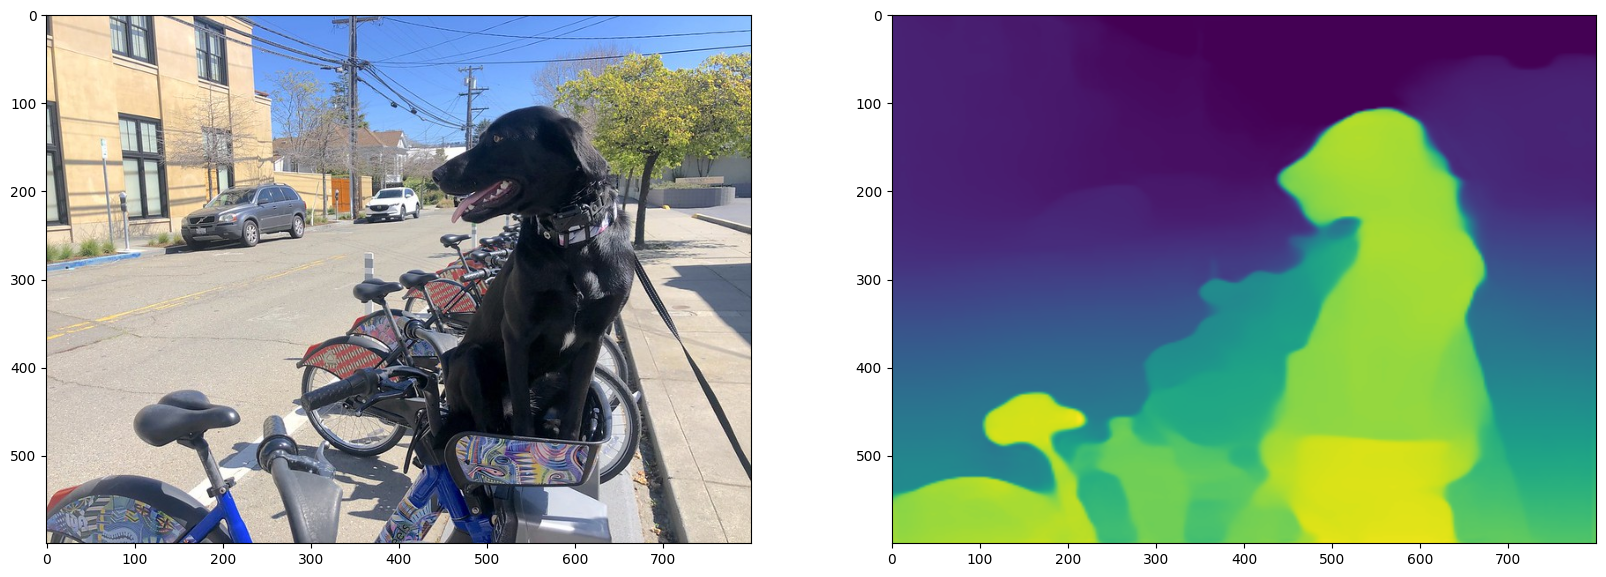

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(to_rgb(image))
ax[1].imshow(result_image);

## Monodepth on Video
[back to top ⬆️](#Table-of-contents:)

By default, only the first 4 seconds are processed in order to quickly check that everything works. Change `NUM_SECONDS` in the cell below to modify this. Set `NUM_SECONDS` to 0 to process the whole video.

### Video Settings
[back to top ⬆️](#Table-of-contents:)


In [11]:
# Video source: https://www.youtube.com/watch?v=fu1xcQdJRws (Public Domain)
VIDEO_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4"
# Number of seconds of input video to process. Set `NUM_SECONDS` to 0 to process
# the full video.
NUM_SECONDS = 4
# Set `ADVANCE_FRAMES` to 1 to process every frame from the input video
# Set `ADVANCE_FRAMES` to 2 to process every second frame. This reduces
# the time it takes to process the video.
ADVANCE_FRAMES = 2
# Set `SCALE_OUTPUT` to reduce the size of the result video
# If `SCALE_OUTPUT` is 0.5, the width and height of the result video
# will be half the width and height of the input video.
SCALE_OUTPUT = 0.5
# The format to use for video encoding. The 'vp09` is slow,
# but it works on most systems.
# Try the `THEO` encoding if you have FFMPEG installed.
# FOURCC = cv2.VideoWriter_fourcc(*"THEO")
FOURCC = cv2.VideoWriter_fourcc(*"vp09")

# Create Path objects for the input video and the result video.
output_directory = Path("output")
output_directory.mkdir(exist_ok=True)
result_video_path = output_directory / f"{Path(VIDEO_FILE).stem}_monodepth.mp4"

### Load the Video
[back to top ⬆️](#Table-of-contents:)

Load the video from a `VIDEO_FILE`, set in the *Video Settings* cell above. Open the video to read the frame width and height and fps, and compute values for these properties for the monodepth video.

In [12]:
cap = cv2.VideoCapture(str(VIDEO_FILE))
ret, image = cap.read()
if not ret:
    raise ValueError(f"The video at {VIDEO_FILE} cannot be read.")
input_fps = cap.get(cv2.CAP_PROP_FPS)
input_video_frame_height, input_video_frame_width = image.shape[:2]

target_fps = input_fps / ADVANCE_FRAMES
target_frame_height = int(input_video_frame_height * SCALE_OUTPUT)
target_frame_width = int(input_video_frame_width * SCALE_OUTPUT)

cap.release()
print(
    f"The input video has a frame width of {input_video_frame_width}, "
    f"frame height of {input_video_frame_height} and runs at {input_fps:.2f} fps"
)
print(
    "The monodepth video will be scaled with a factor "
    f"{SCALE_OUTPUT}, have width {target_frame_width}, "
    f" height {target_frame_height}, and run at {target_fps:.2f} fps"
)

The input video has a frame width of 640, frame height of 360 and runs at 30.00 fps
The monodepth video will be scaled with a factor 0.5, have width 320,  height 180, and run at 15.00 fps


### Do Inference on a Video and Create Monodepth Video
[back to top ⬆️](#Table-of-contents:)


In [13]:
# Initialize variables.
input_video_frame_nr = 0
start_time = time.perf_counter()
total_inference_duration = 0

# Open the input video
cap = cv2.VideoCapture(str(VIDEO_FILE))

# Create a result video.
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    target_fps,
    (target_frame_width * 2, target_frame_height),
)

num_frames = int(NUM_SECONDS * input_fps)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if num_frames == 0 else num_frames
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if input_video_frame_nr >= total_frames:
            break

        # Only process every second frame.
        # Prepare a frame for inference.
        # Resize to the input shape for network.
        resized_image = cv2.resize(src=image, dsize=(network_image_height, network_image_width))
        # Reshape the image to network input shape NCHW.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

        # Do inference.
        inference_start_time = time.perf_counter()
        result = compiled_model([input_image])[output_key]
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        if input_video_frame_nr % (10 * ADVANCE_FRAMES) == 0:
            clear_output(wait=True)
            progress_bar.display()
            # input_video_frame_nr // ADVANCE_FRAMES gives the number of
            # Frames that have been processed by the network.
            display(
                Pretty(
                    f"Processed frame {input_video_frame_nr // ADVANCE_FRAMES}"
                    f"/{total_frames // ADVANCE_FRAMES}. "
                    f"Inference time per frame: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )

        # Transform the network result to a RGB image.
        result_frame = to_rgb(convert_result_to_image(result))
        # Resize the image and the result to a target frame shape.
        result_frame = cv2.resize(result_frame, (target_frame_width, target_frame_height))
        image = cv2.resize(image, (target_frame_width, target_frame_height))
        # Put the image and the result side by side.
        stacked_frame = np.hstack((image, result_frame))
        # Save a frame to the video.
        out_video.write(stacked_frame)

        input_video_frame_nr = input_video_frame_nr + ADVANCE_FRAMES
        cap.set(1, input_video_frame_nr)

        progress_bar.progress = input_video_frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
finally:
    clear_output()
    processed_frames = num_frames // ADVANCE_FRAMES
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time

    print(
        f"Processed {processed_frames} frames in {duration:.2f} seconds. "
        f"Total FPS (including video processing): {processed_frames/duration:.2f}."
        f"Inference FPS: {processed_frames/total_inference_duration:.2f} "
    )
    print(f"Monodepth Video saved to '{str(result_video_path)}'.")

Processed 60 frames in 97.70 seconds. Total FPS (including video processing): 0.61.Inference FPS: 82.48 
Monodepth Video saved to 'output/Coco%20Walking%20in%20Berkeley_monodepth.mp4'.


### Display Monodepth Video
[back to top ⬆️](#Table-of-contents:)


In [14]:
video = Video(result_video_path, width=800, embed=True)
if not result_video_path.exists():
    plt.imshow(stacked_frame)
    raise ValueError("OpenCV was unable to write the video file. Showing one video frame.")
else:
    print(f"Showing monodepth video saved at\n{result_video_path.resolve()}")
    print(
        "If you cannot see the video in your browser, please click on the "
        "following link to download the video "
    )
    video_link = FileLink(result_video_path)
    video_link.html_link_str = "<a href='%s' download>%s</a>"
    display(HTML(video_link._repr_html_()))
    display(video)

Showing monodepth video saved at
/home/ea/work/openvino_notebooks/notebooks/201-vision-monodepth/output/Coco%20Walking%20in%20Berkeley_monodepth.mp4
If you cannot see the video in your browser, please click on the following link to download the video 
